**Importing libraries**

In [1]:
import numpy as np 
import pandas as pd 
import multiprocessing as multi
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt

**Defining plotting parameters**

In [2]:
dpi = 90

**Defining constants**

In [3]:
omega_m = 0.272            #matter density paratmeter from Komatsu et al. (2011) 
omega_l = 1 - omega_m      #vacuum density paratmeter assuming flat universe
H_o = 70.4                 #Hubble constant in km s^−1 Mpc^−1 from Komatsu et al. (2011) 
h = 0.704
f = omega_m**0.545         #linear velocity growth rate from Tanimura et al. (2020)


**Defining Functions**

In [4]:
def H(z):                           #hubble parameter (in km s^-1 Mpc^-1) using Eq. 4.33 in Peter's book
    return np.sqrt( H_o**2 * ( (1+z)**3 * omega_m + omega_l ) ) 


**Reading galaxies dataset**

In [5]:
%%time
z = 0.42372720
# data_address = '../input/magneticumsnap027z042-massfiltered/'
data_address = 'Data/'
df_gal = pd.read_csv(data_address + 'massive_galaxies.csv')      #massive_galaxies.csv contains galaxies with mass greater than 1.8 ×10^{11} h^{−1} M_sun as done by Tanimura et al. (2020)
print(df_gal.describe())


            x[kpc/h]       y[kpc/h]       z[kpc/h]     m[Msol/h]
count   93097.000000   93097.000000   93097.000000  9.309700e+04
mean   325576.133087  322500.028738  320613.762863  3.993206e+11
std    184863.273960  182799.587421  183249.915097  3.995129e+11
min         1.864417      10.164207       0.260974  1.800010e+11
25%    163866.950000  166201.380000  162514.560000  2.161480e+11
50%    332449.620000  329260.160000  319925.780000  2.784900e+11
75%    483949.000000  475466.120000  478698.410000  4.192930e+11
max    639996.190000  639980.940000  639993.120000  1.077460e+13
CPU times: user 99.9 ms, sys: 3.98 ms, total: 104 ms
Wall time: 103 ms


**Reading clusters dataset**

In [6]:
%%time

df_clusters = pd.read_csv(data_address + 'massive_clusters.csv', 
                          usecols = ['x[kpc/h]', 'y[kpc/h]', 'z[kpc/h]', 'm500c[Msol/h]', 'vx[km/s]', 'vy[km/s]', 'vz[km/s]'    ])  #massive_clusters.csv contains clusters with M_500c greater than 10^13.5 h^{-1} M_sun as done by Tanimura et al. (2020)

#removing cluster at edges of the survey volume as done by Tanimura et al. 2020
df_clusters = df_clusters[(df_clusters['x[kpc/h]'] > 120000) & (df_clusters['x[kpc/h]'] < 520000) 
                          & (df_clusters['y[kpc/h]'] > 120000) & (df_clusters['y[kpc/h]'] < 520000) 
                          & (df_clusters['z[kpc/h]'] > 120000) & (df_clusters['z[kpc/h]'] < 520000)]
        
print(df_clusters.describe())

            x[kpc/h]       y[kpc/h]       z[kpc/h]  m500c[Msol/h]  \
count    1486.000000    1486.000000    1486.000000   1.486000e+03   
mean   321167.437921  325547.000289  314873.843149   6.320741e+13   
std    115128.818045  114647.361770  114015.385111   4.882252e+13   
min    120050.600000  121580.500000  120140.480000   3.163600e+13   
25%    224259.405000  231868.690000  219766.045000   3.818072e+13   
50%    324557.625000  331498.735000  309916.205000   4.799315e+13   
75%    419428.657500  425986.122500  415948.492500   7.034382e+13   
max    519955.530000  519124.750000  519470.590000   7.220310e+14   

          vx[km/s]     vy[km/s]     vz[km/s]  
count  1486.000000  1486.000000  1486.000000  
mean     60.044705    55.125112    -9.400921  
std     283.156687   296.834432   279.764800  
min   -1179.530000 -1107.410000 -1064.920000  
25%    -114.970000  -134.777000  -190.498500  
50%      59.041100    69.447850   -16.468200  
75%     237.558000   257.186750   176.384000  
ma

**Specifying prefactors for Eq. 1 of Tanimura et al. (2020)**

In [7]:
a = 1/(1+z)
H(z)
print(H(z))

pre_fac = (f * a * H(z) / (4 * np.pi))           #in km s^−1 Mpc^−1 
pre_fac

86.593806237


2.3806208666680271

**Calculating mean density of the simulation box for Eq. 1**

In [8]:
def delta_gal_mean_func(cell_size):
    
    df_gal_mean = df_gal.copy()

    df_gal_mean['x[kpc/h]'] = df_gal_mean['x[kpc/h]'] / cell_size
    df_gal_mean['y[kpc/h]'] = df_gal_mean['y[kpc/h]'] / cell_size
    df_gal_mean['z[kpc/h]'] = df_gal_mean['z[kpc/h]'] / cell_size

    #making tuples, converting tuples to cell coordinates
    df_gal_mean["cell"] = list(zip(df_gal_mean['x[kpc/h]'].astype(int), df_gal_mean['y[kpc/h]'].astype(int), df_gal_mean['z[kpc/h]'].astype(int)))

    #array to store number of galaxies in the cells
    gals_in_cell = np.zeros((640000//cell_size, 640000//cell_size, 640000//cell_size))
    
    #counting number of galaxies in the cells
    for cell in df_gal_mean["cell"]:
        x, y, z = cell
        gals_in_cell[x, y, z] += 1

    delta_gal_mean = np.mean(gals_in_cell)
    
    return delta_gal_mean

**Calculating Overdensity field for Eq. 1**

In [9]:
b = 2                                #bias for LOWZ & CMASS galaxies as taken by Tanimura et al. 2020

def overdensity_field_calc(clus_x, clus_y, clus_z, delta_gal_mean, cell_size, sigma_in_pix):

    #converting strings into floats
    clus_x = float(clus_x); clus_y = float(clus_y); clus_z = float(clus_z)
    
    #filtering galaxies in a cube of 240,000 h^-1 kpc around the given cluster
    df_gal_select = df_gal[(df_gal['x[kpc/h]'] > (clus_x - 120000)) & (df_gal['x[kpc/h]'] < (clus_x + 120000))
                            & (df_gal['y[kpc/h]'] > (clus_y - 120000)) & (df_gal['y[kpc/h]'] < (clus_y + 120000)) 
                             & (df_gal['z[kpc/h]'] > (clus_z - 120000)) & (df_gal['z[kpc/h]'] < (clus_z + 120000))]
    
    #making copy to extract coordinates of cells containing the galaxies
    df_gal_cube = df_gal_select.copy()
    
    #moving the galxies cube to lie within 0 to 240,000 h^-1 kpc 
    df_gal_cube['x[kpc/h]'] -= (clus_x-120000)
    df_gal_cube['y[kpc/h]'] -= (clus_y-120000)
    df_gal_cube['z[kpc/h]'] -= (clus_z-120000)

    #dividing by 5000 (integer-div) so we get cell coordinates
    df_gal_cube['x[kpc/h]'] = df_gal_cube['x[kpc/h]'] / cell_size
    df_gal_cube['y[kpc/h]'] = df_gal_cube['y[kpc/h]'] / cell_size
    df_gal_cube['z[kpc/h]'] = df_gal_cube['z[kpc/h]'] / cell_size
    
    #making tuples, converting tuples to cell coordinates
    df_gal_cube["cell"] = list(zip(df_gal_cube['x[kpc/h]'].astype(int), df_gal_cube['y[kpc/h]'].astype(int), df_gal_cube['z[kpc/h]'].astype(int)))
    
    #array to store number of galaxies in the cells
    gals_in_cell = np.zeros((240000//cell_size, 240000//cell_size, 240000//cell_size))
    
    #counting number of galaxies in the cells
    for cell in df_gal_cube["cell"]:
        x, y, z = cell
        gals_in_cell[x, y, z] += 1
        
    #determining the overdensity of galaxies    
    delta_gal = (gals_in_cell/delta_gal_mean) - 1
    
    #smoothing the overdensity of galaxies
    delta_gal_smooth = gaussian_filter(delta_gal, sigma = sigma_in_pix)
        
    #obtaining matter overdensity from galaxies overdensity
    delta_matter = delta_gal_smooth / b
    
    return delta_matter


**Calculating differential, numerator & denominator for Eq. 1**

In [10]:
def vel_terms_calc(cell_size):
    
    #calculating the differential in the Eq. 1
    dy_cubed = cell_size**3
    
    #specifing position of the clusters
    Rclus_x = np.zeros((240000//cell_size, 240000//cell_size, 240000//cell_size))
    Rclus_x[:] = 120000
    Rclus_y = np.zeros((240000//cell_size, 240000//cell_size, 240000//cell_size))
    Rclus_y[:] = 120000
    Rclus_z = np.zeros((240000//cell_size, 240000//cell_size, 240000//cell_size))
    Rclus_z[:] = 120000

    #generating meshgrid containing coordinates of the centers of cells
    Rcell_x = np.zeros((240000//cell_size, 240000//cell_size, 240000//cell_size))
    Rcell_y = np.zeros((240000//cell_size, 240000//cell_size, 240000//cell_size))
    Rcell_z = np.zeros((240000//cell_size, 240000//cell_size, 240000//cell_size))

    for i, val in enumerate(range(cell_size//2, 238000, cell_size)):
        Rcell_x[i,:,:] = val
        Rcell_y[:,i,:] = val
        Rcell_z[:,:,i] = val

    #evaluating the term in the denominator of Eq. 1 of Tanimura et al. 2020
    denom = np.sqrt((Rcell_x - Rclus_x)**2 + (Rcell_y - Rclus_y)**2 + (Rcell_z - Rclus_z)**2)**(3)

    #evaluating the direction term in the numerator of Eq. 1
    numer_x = Rcell_x - Rclus_x
    numer_y = Rcell_y - Rclus_y
    numer_z = Rcell_z - Rclus_z
    
    return (dy_cubed, numer_x, numer_y, numer_z, denom)


**Calculating velocity of clusters according to Eq. 1**

In [11]:
def clus_velocity_calc(clus_x, clus_y, clus_z, delta_gal_mean, cell_size, vel_terms, sigma_in_pix):
    
    delta_matter = overdensity_field_calc(clus_x, clus_y, clus_z, delta_gal_mean, cell_size, sigma_in_pix)
    
    
    dy_cubed, numer_x, numer_y, numer_z, denom = vel_terms
       
    #estimating velocity in x direction
    integrand_x = dy_cubed * delta_matter * (numer_x/(h*1e3)) / denom #in units of Mpc    
    vx_est = pre_fac * np.sum(integrand_x)
        
    #estimating velocity in y direction
    integrand_y = dy_cubed * delta_matter * (numer_y/(h*1e3)) / denom #in units of Mpc    
    vy_est = pre_fac * np.sum(integrand_y)
    
    #estimating velocity in z direction
    integrand_z = dy_cubed * delta_matter * (numer_z/(h*1e3)) / denom #in units of Mpc    
    vz_est = pre_fac * np.sum(integrand_z)
    
    return(vx_est, vy_est, vz_est)


**Calculating sigma for smoothing**

In [12]:
def sigma_calc(cell_size):
    
    FWHM = 2000                           #h^-1 kpc, of Gaussian kernel, taken by Tanimura et al. 2020
    FWHM_in_pix = FWHM/cell_size          #in pixel units
    sigma_in_pix = FWHM_in_pix/(2.35482)  #in pixel units
    
    return sigma_in_pix

**Calling funtion to estimate the velocity of clusters**

In [82]:
%%time

cell_size_assess = pd.DataFrame(columns=['Cell Size', 'Mean - Vx', 'Mean - Vy', 'Mean - Vz', 
                                         'SD - Vx', 'SD - Vy', 'SD - Vz', 'r - Vx', 'r - Vy','r - Vz'])

for size in [2000, 4000, 5000, 8000, 10000, 20000]:

    cell_size = size                      #h^-1 kpc, size of pixel or cell

    sigma_in_pix = sigma_calc(cell_size)

    delta_gal_mean = delta_gal_mean_func(cell_size)

    vel_terms = vel_terms_calc(cell_size)

    clus_param = list(zip(df_clusters['x[kpc/h]'], df_clusters['y[kpc/h]'], df_clusters['z[kpc/h]'], 
                          [delta_gal_mean]*len(df_clusters), [cell_size]*len(df_clusters), 
                          [vel_terms]*len(df_clusters), [sigma_in_pix]*len(df_clusters)))

    # pool = multi.Pool(processes = 8)
    pool = multi.Pool(processes = 42)
    v_est = pool.starmap(clus_velocity_calc, clus_param)

    vx_est_list = [i[0] for i in v_est]
    vy_est_list = [i[1] for i in v_est]
    vz_est_list = [i[2] for i in v_est]
    
    error_x = df_clusters['vx[km/s]'] - vx_est_list
    error_y = df_clusters['vy[km/s]'] - vy_est_list
    error_z = df_clusters['vz[km/s]'] - vz_est_list
    
    cell_size_assess = cell_size_assess.append({'Cell Size':size, 
                             'Mean - Vx': round(np.mean(error_x),1), 
                             'Mean - Vy': round(np.mean(error_y),1), 
                             'Mean - Vz': round(np.mean(error_z),1), 
                             'SD - Vx': round(np.std(error_x),1), 
                             'SD - Vy': round(np.std(error_y),1),
                             'SD - Vz': round(np.std(error_z),1), 
                             'r - Vx': round(np.corrcoef(df_clusters['vx[km/s]'], vx_est_list)[1,0],2),
                             'r - Vy': round(np.corrcoef(df_clusters['vy[km/s]'], vy_est_list)[1,0],2),
                             'r - Vz': round(np.corrcoef(df_clusters['vz[km/s]'], vz_est_list)[1,0],2)}, 
                             ignore_index=True)
    
    
print(cell_size_assess)

   Cell Size  Mean - Vx  Mean - Vy  Mean - Vz  SD - Vx  SD - Vy  SD - Vz  \
0     2000.0     -656.3     -676.6     -727.1    899.2    901.2    899.3   
1     4000.0     -174.7     -187.2     -235.8    404.8    407.6    392.9   
2     5000.0      -96.4     -105.6     -149.1    302.2    302.6    289.8   
3     8000.0      -11.8      -18.2      -64.5    184.2    200.8    179.8   
4    10000.0        7.4        1.6      -42.7    162.2    179.8    155.3   
5    20000.0       41.7       30.3      -17.2    167.6    188.7    163.6   

   r - Vx  r - Vy  r - Vz  
0    0.38    0.37    0.40  
1    0.61    0.60    0.63  
2    0.68    0.68    0.71  
3    0.80    0.76    0.81  
4    0.82    0.80    0.84  
5    0.82    0.80    0.82  
CPU times: user 20.7 s, sys: 3min 32s, total: 3min 53s
Wall time: 2min 5s


In [83]:
cell_size_assess

,Cell Size,Mean - Vx,Mean - Vy,Mean - Vz,SD - Vx,SD - Vy,SD - Vz,r - Vx,r - Vy,r - Vz
0,2000.0,-656.3,-676.6,-727.1,899.2,901.2,899.3,0.38,0.37,0.40
1,4000.0,-174.7,-187.2,-235.8,404.8,407.6,392.9,0.61,0.60,0.63
2,5000.0,-96.4,-105.6,-149.1,302.2,302.6,289.8,0.68,0.68,0.71
3,8000.0,-11.8,-18.2,-64.5,184.2,200.8,179.8,0.80,0.76,0.81
4,10000.0,7.4,1.6,-42.7,162.2,179.8,155.3,0.82,0.80,0.84
5,20000.0,41.7,30.3,-17.2,167.6,188.7,163.6,0.82,0.80,0.82


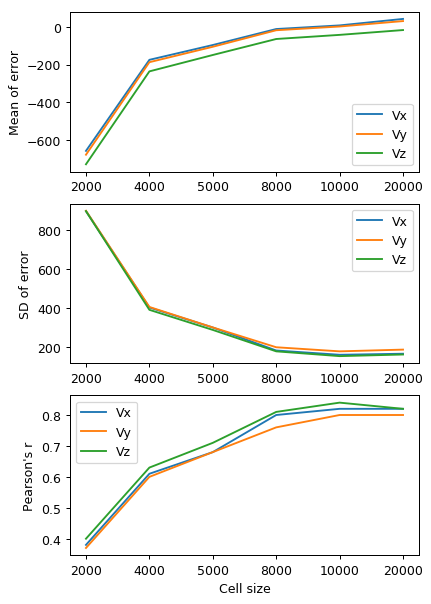

In [84]:
plt.figure(dpi = dpi, figsize = (5,8))
plt.subplot(311)
plt.plot(cell_size_assess['Mean - Vx'], label = 'Vx')
plt.plot(cell_size_assess['Mean - Vy'], label = 'Vy')
plt.plot(cell_size_assess['Mean - Vz'], label = 'Vz')
plt.legend()
plt.ylabel('Mean of error')
plt.xticks([0, 1, 2, 3, 4, 5], [2000, 4000, 5000, 8000, 10000, 20000])

plt.subplot(312)
plt.plot(cell_size_assess['SD - Vx'], label = 'Vx')
plt.plot(cell_size_assess['SD - Vy'], label = 'Vy')
plt.plot(cell_size_assess['SD - Vz'], label = 'Vz')
plt.legend()
plt.ylabel('SD of error')
plt.xticks([0, 1, 2, 3, 4, 5], [2000, 4000, 5000, 8000, 10000, 20000])

plt.subplot(313)
plt.plot(cell_size_assess['r - Vx'], label = 'Vx')
plt.plot(cell_size_assess['r - Vy'], label = 'Vy')
plt.plot(cell_size_assess['r - Vz'], label = 'Vz')
plt.legend()
plt.xlabel('Cell size')
plt.ylabel('Pearson\'s r')
plt.xticks([0, 1, 2, 3, 4, 5], [2000, 4000, 5000, 8000, 10000, 20000]);

In [85]:
%%time
cell_size = 10000                      #h^-1 kpc, size of pixel or cell



sigma_in_pix = sigma_calc(cell_size)

delta_gal_mean = delta_gal_mean_func(cell_size)

vel_terms = vel_terms_calc(cell_size)

clus_param = list(zip(df_clusters['x[kpc/h]'], df_clusters['y[kpc/h]'], df_clusters['z[kpc/h]'], 
                      [delta_gal_mean]*len(df_clusters), [cell_size]*len(df_clusters), 
                      [vel_terms]*len(df_clusters), [sigma_in_pix]*len(df_clusters)))

# pool = multi.Pool(processes = 8)
pool = multi.Pool(processes = 21)
v_est = pool.starmap(clus_velocity_calc, clus_param)

vx_est_list = [i[0] for i in v_est]
vy_est_list = [i[1] for i in v_est]
vz_est_list = [i[2] for i in v_est]

error_x = df_clusters['vx[km/s]'] - vx_est_list
error_y = df_clusters['vy[km/s]'] - vy_est_list
error_z = df_clusters['vz[km/s]'] - vz_est_list

# cell_size_assess = cell_size_assess.append({'Cell Size':cell_size, 'Mean - Vx': np.mean(error_x), 'Mean - Vy': np.mean(error_y), 
#                              'Mean - Vy': np.mean(error_z), 'SD - Vx': np.std(error_x), 'SD - Vy':np.std(error_y),
#                              'SD - Vz': np.std(error_z), 'r - Vx': np.corrcoef(df_clusters['vx[km/s]'], vx_est_list)[1,0],
#                              'r - Vy': np.corrcoef(df_clusters['vy[km/s]'], vy_est_list)[1,0],
#                              'r - Vz': np.corrcoef(df_clusters['vz[km/s]'], vz_est_list)[1,0]}, ignore_index=True)
# print(cell_size_assess)

CPU times: user 983 ms, sys: 18.5 s, total: 19.5 s
Wall time: 7.61 s


**Assessing the correctness of the estimated velocities**

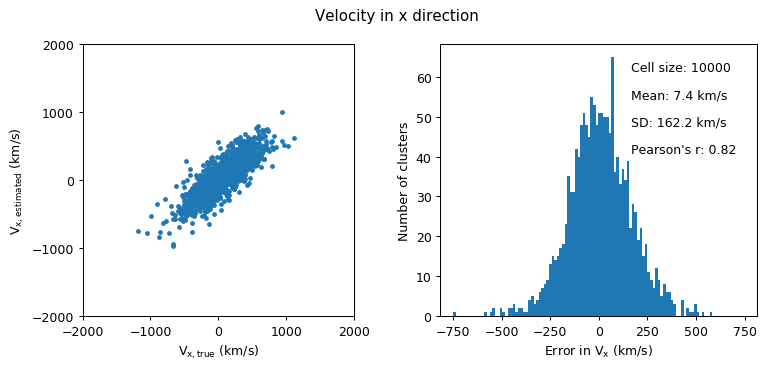

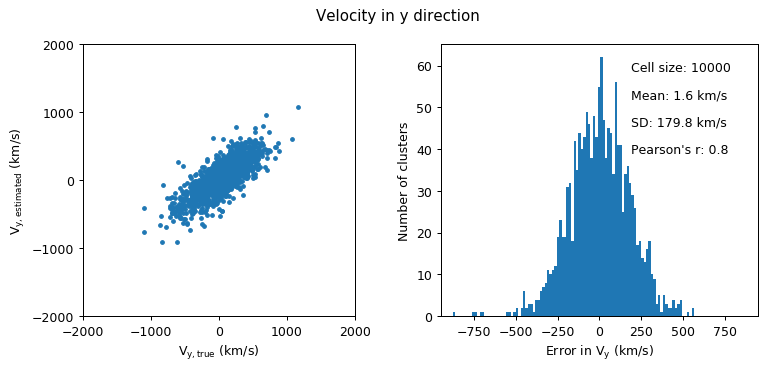

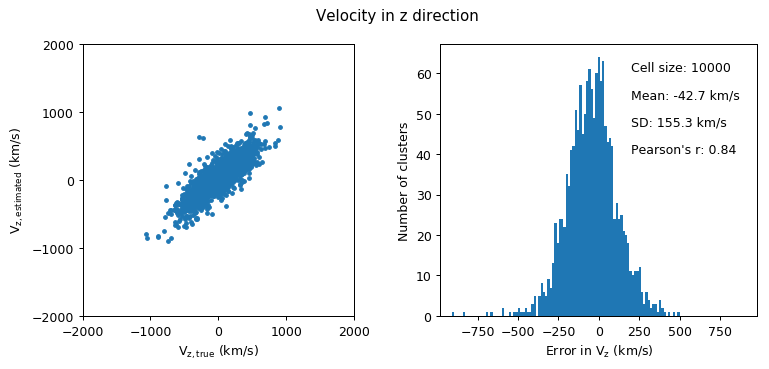

In [89]:
fig = plt.figure(dpi = dpi, figsize = (10,4))

plt.subplot(1,2,1)
plt.scatter(df_clusters['vx[km/s]'], vx_est_list, s = 8)
plt.xlabel('V$_\mathrm{x, true}$ (km/s)')
plt.ylabel('V$_\mathrm{x, estimated}$ (km/s)')
plt.gca().set_xticks(range(-2000, 2001, 1000))
plt.gca().set_yticks(range(-2000, 2001, 1000))
plt.ylim(-2000,2000)
plt.gca().set_aspect('equal', adjustable='box')

plt.subplot(1,2,2)
error_x = df_clusters['vx[km/s]'] - vx_est_list
plt.hist(error_x, bins = 100)
plt.xlabel('Error in V$_{\mathrm{x}}$ (km/s)')
plt.ylabel('Number of clusters')
x_low, x_high = plt.xlim()
plt.xlim(x_low, abs(x_low))

plt.text(0.6, 0.90, f'Cell size: {cell_size}', transform=plt.gca().transAxes)
plt.text(0.6, 0.80, f'Mean: {round(np.mean(error_x), 1)} km/s', transform=plt.gca().transAxes)
plt.text(0.6, 0.70, f'SD: {round(np.std(error_x), 1)} km/s', transform=plt.gca().transAxes)
r_vx = np.corrcoef(df_clusters['vx[km/s]'], vx_est_list)[1,0]
plt.text(0.6, 0.60, f'Pearson\'s r: {round(r_vx, 2)}', transform=plt.gca().transAxes)

fig.suptitle('Velocity in x direction')




fig_y = plt.figure(dpi = dpi, figsize = (10,4))
plt.subplot(1,2,1)
plt.scatter(df_clusters['vy[km/s]'], vy_est_list, s = 8)
plt.xlabel('V$_\mathrm{y, true}$ (km/s)')
plt.ylabel('V$_\mathrm{y, estimated}$ (km/s)')
plt.gca().set_xticks(range(-2000, 2001, 1000))
plt.gca().set_yticks(range(-2000, 2001, 1000))
plt.ylim(-2000,2000)
plt.gca().set_aspect('equal', adjustable='box')

plt.subplot(1,2,2)
error_y = df_clusters['vy[km/s]'] - vy_est_list
plt.hist(error_y, bins = 100)
plt.xlabel('Error in V$_{\mathrm{y}}$ (km/s)')
plt.ylabel('Number of clusters')
x_low, x_high = plt.xlim()
plt.xlim(x_low, abs(x_low))

plt.text(0.6, 0.90, f'Cell size: {cell_size}', transform=plt.gca().transAxes)
plt.text(0.6, 0.80, f'Mean: {round(np.mean(error_y), 1)} km/s', transform=plt.gca().transAxes)
plt.text(0.6, 0.70, f'SD: {round(np.std(error_y), 1)} km/s', transform=plt.gca().transAxes)
r_vy = np.corrcoef(df_clusters['vy[km/s]'], vy_est_list)[1,0]
plt.text(0.6, 0.60, f'Pearson\'s r: {round(r_vy, 2)}', transform=plt.gca().transAxes)

fig_y.suptitle('Velocity in y direction')




fig_z = plt.figure(dpi = dpi, figsize = (10,4))
plt.subplot(1,2,1)
plt.scatter(df_clusters['vz[km/s]'], vz_est_list, s = 8)
plt.xlabel('V$_\mathrm{z, true}$ (km/s)')
plt.ylabel('V$_\mathrm{z, estimated}$ (km/s)');
plt.gca().set_xticks(range(-2000, 2001, 1000))
plt.gca().set_yticks(range(-2000, 2001, 1000))
plt.gca().set_aspect('equal', adjustable='box')

plt.subplot(1,2,2)
error_z = df_clusters['vz[km/s]'] - vz_est_list
plt.hist(error_z, bins = 100)
plt.xlabel('Error in V$_{\mathrm{z}}$ (km/s)')
plt.ylabel('Number of clusters')
x_low, x_high = plt.xlim()
plt.xlim(x_low, abs(x_low))

plt.text(0.6, 0.90, f'Cell size: {cell_size}', transform=plt.gca().transAxes)
plt.text(0.6, 0.80, f'Mean: {round(np.mean(error_z), 1)} km/s', transform=plt.gca().transAxes)
plt.text(0.6, 0.70, f'SD: {round(np.std(error_z), 1)} km/s', transform=plt.gca().transAxes)
r_vz = np.corrcoef(df_clusters['vz[km/s]'], vz_est_list)[1,0]
plt.text(0.6, 0.60, f'Pearson\'s r: {round(r_vz, 2)}', transform=plt.gca().transAxes)

fig_z.suptitle('Velocity in z direction');